In [6]:
### Regressions Ridge et Lasso avec le package glmnet
### Outils: Ridge, Lasso, Elastic Net, Validation croisee
### Dernière mise à jour: 04/03/2020
### Jérémy L Hour

rm(list=ls())

### PACKAGES
#install.packages("glmnet")
library("MASS")
library("glmnet")

### FONCTIONS UTILISATEURS
source("functions/DataSim.R") 

#################################
#################################
### 1. SIMULATION DES DONNEES ###
#################################
#################################

set.seed(12071990)
n = 5000
data = DataSim(n, p=20, Ry= .2, Intercept=F)
# separation en train et test
ytrain = data$y[1:(n/2)]; Xtrain = data$X[1:(n/2),] 
ytest  = data$y[-(1:(n/2))]; Xtest = data$X[-(1:(n/2)),]

In [8]:
##############
##############
### 2. MCO ###
##############
##############

mco = lm(ytrain ~ Xtrain)

# calcul de l'erreur sur le jeu de test
mco.hat = predict(mco,as.data.frame(Xtest))
print(paste("Erreur de test MCO: ",mean((ytest-mco.hat)^2)))

[1] "Erreur de test MCO:  1.80287251220601"


[1] "Nombre de coefficients nuls:  0"


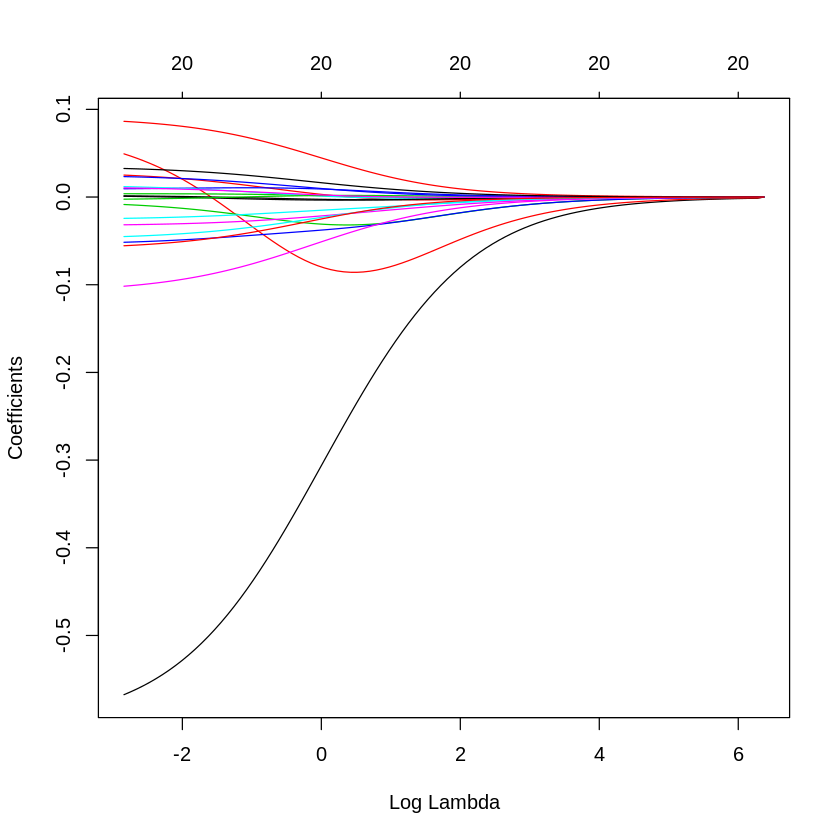

In [10]:
#####################################
#####################################
### 3. REGRESSION RIDGE (ALPHA=0) ###
#####################################
#####################################

Ridge = glmnet(Xtrain,ytrain, family="gaussian",alpha=0)

# Ridge$beta est une matrice où chaque colonne collecte l'estimateur Ridge pour une valeur donnee de lambda
# Prenons une valeur arbitraire
bRidge = c(Ridge$beta[,6])
print(paste("Nombre de coefficients nuls: ",sum(bRidge == 0)))
# aucun coefficient n'est strictement nul

# le package glmnet permet de visualiser la trajectoire des coefficients a mesure que lambda croit
plot(Ridge, xvar="lambda")

In [11]:
### Mise en oeuvre de la validation croisee pour choisir lambda
## A. de facon automatique avec le package
cv.ridge = cv.glmnet(Xtrain,ytrain, family="gaussian",alpha=0,nfolds=5)
print(paste("Lambda CV = ",cv.ridge$lambda.min))

ridge.hat = predict(cv.ridge,Xtest)
print(paste("Erreur de test Ridge, validation croisée glmnet: ",mean((ytest-ridge.hat)^2)))

# il est également possible de paralléliser la validation croisée.

## B. de facon artisanale (pour bien comprendre la validation croisee)
K = 5
lambda.set = c(seq(.001,1,by=.01),seq(1.1,100,by=5))
lambda.set = sort(lambda.set,decreasing=T)

cv.group = sample(1:K,size=n/2,replace=T)
cv.error = matrix(nrow=K, ncol=length(lambda.set))
for(k in 1:K){
    yk = ytrain[cv.group == k]; ynk = ytrain[cv.group != k]
    Xk = Xtrain[cv.group == k,]; Xnk = Xtrain[cv.group != k,]
    
    # calcul sur les "nk"
    ridge = glmnet(Xnk,ynk, family="gaussian",alpha=0,lambda=lambda.set)
    
    # prediction sur les "k"
    ridge.hat = predict(ridge,Xk)
    
    # calcul de l'erreur
    cv.error[k,] = mapply(function(d) sum((yk-ridge.hat[,d])^2),1:ncol(ridge.hat))
}

# on aggrege les erreurs et on calcule le lambda optimal
cv.error = apply(cv.error,2,sum)
lambda.cv = lambda.set[which(cv.error==min(cv.error))]
print(paste("Lambda CV à la main = ",lambda.cv))
                          
Ridge = glmnet(Xtrain,ytrain, family="gaussian",alpha=0,lambda=lambda.cv) # calcul de l'estimateur pour la valeur de lambda choisie
ridge.hat.cv = predict(Ridge,Xtest)
print(paste("Erreur de test Ridge, validation croisée à la main: ",mean((ytest-ridge.hat.cv)^2)))

[1] "Lambda CV =  0.0584317228346957"
[1] "Erreur de test Ridge, validation croisée glmnet:  1.10153148606031"
[1] "Lambda CV à la main =  0.041"
[1] "Erreur de test Ridge, validation croisée à la main:  1.06992229313774"


[1] "Nombre de coefficients nuls:  19"
[1] "Lambda CV Lasso =  0.0170331571715176"
[1] "Erreur de test Lasso:  1.08526249936336"


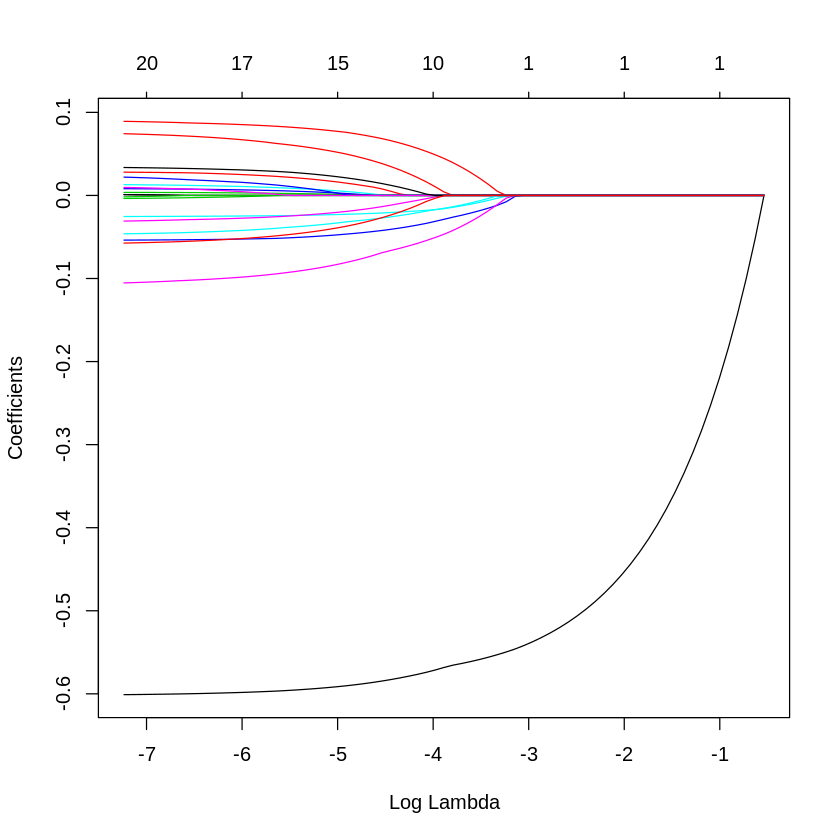

In [12]:
#####################################
#####################################
### 4. REGRESSION LASSO (ALPHA=1) ###
#####################################
#####################################

lasso = glmnet(Xtrain,ytrain, family="gaussian",alpha=1)

# Prenons une valeur arbitraire
blasso = c(lasso$beta[,6])
print(paste("Nombre de coefficients nuls: ",sum(blasso == 0)))
# plusieurs coefficients sont nuls

# on constate egalement que ce n'est pas le meme profil de regularisation
plot(lasso, xvar="lambda")

# validation croisee pour le choix du lambda
cv.lasso = cv.glmnet(Xtrain,ytrain, family="gaussian",alpha=1,nfolds=5)
print(paste("Lambda CV Lasso = ",cv.lasso$lambda.min))

lasso.hat = predict(cv.lasso,Xtest)
print(paste("Erreur de test Lasso: ",mean((ytest-lasso.hat)^2)))

In [13]:
#####################################
#####################################
### 5. ELASTIC NET (0 < ALPHA <1) ###
#####################################
#####################################

elastic = glmnet(Xtrain,ytrain, family="gaussian",alpha=.5)

# Prenons une valeur arbitraire
belastic = c(elastic$beta[,6])
print(paste("Nombre de coefficients nuls: ",sum(belastic == 0)))
# plusieurs coefficients sont nuls egalement

# Malheureusement glmnet ne permet pas de choisir alpha avec une fonction sympathique
# Il faut mettre la procedure de valdiation croisee en place soi meme
# on peut le faire uniquement pour lambda a alpha donne
# note: boucler sur alpha n'est pas une bonne idée car la partition pour choisir lambda va être recalculée à chaque valeur de alpha

cv.elastic = cv.glmnet(Xtrain,ytrain, family="gaussian",alpha=.5,nfolds=5)
elastic.hat = predict(cv.elastic,Xtest)
print(paste("Erreur de test Elastic Net: ",mean((ytest-elastic.hat)^2)))

[1] "Nombre de coefficients nuls:  19"
[1] "Erreur de test Eslatic Net:  1.07752262411256"


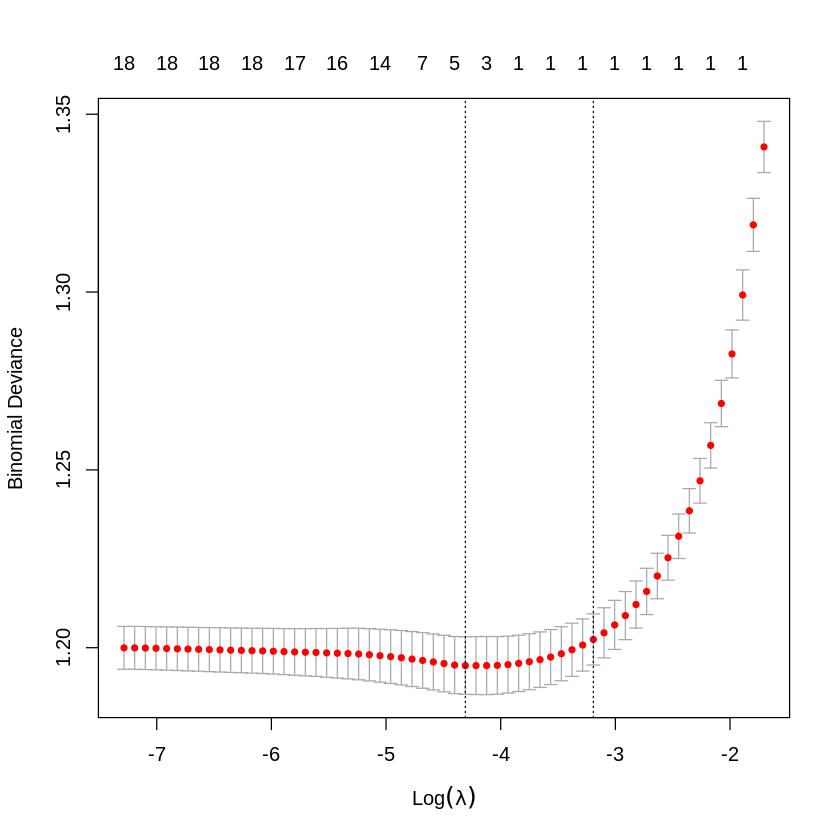

ytest_hat
   0    1 
 592 1908 

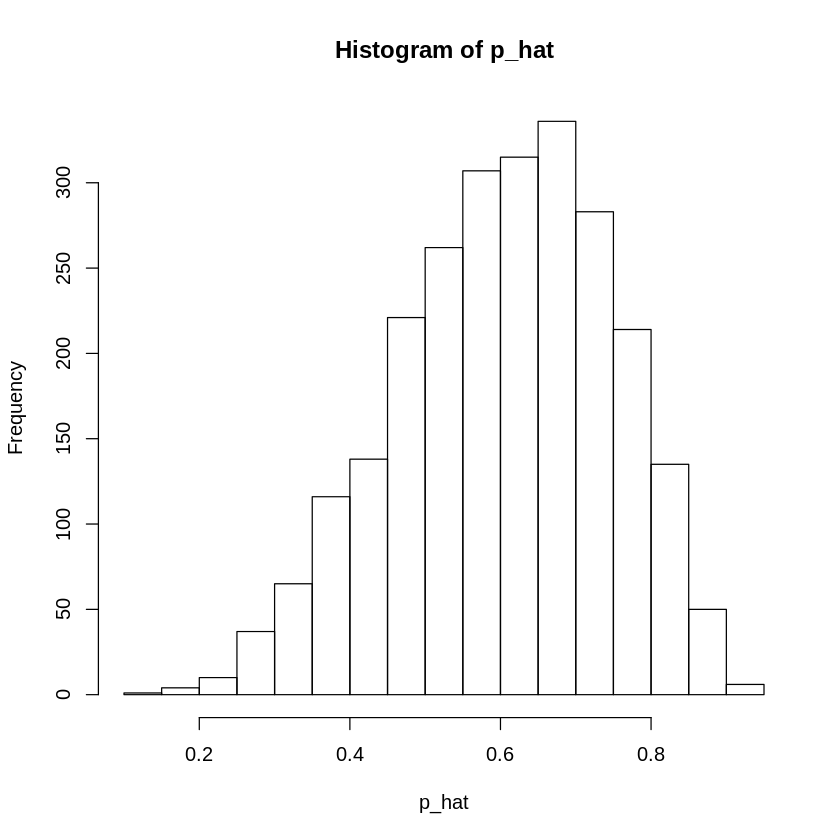

In [18]:
##########################################
##########################################
### 6. REGRESSION LOGISTIQUE PENALISEE ###
##########################################
##########################################

ytrain_bin = 1*(ytrain>0); ytest_bin = 1*(ytest>0)

logit_lasso = cv.glmnet(Xtrain,ytrain_bin,family="binomial",alpha=1,nfolds=5)
plot(logit_lasso)

p_hat = predict(logit_lasso,Xtest,type="response") # predit la probabilité que y = 1 | X
hist(p_hat)

ytest_hat = predict(logit_lasso,Xtest,type="class") # predit la classe la plus probable
table(ytest_hat)

In [ ]:
summary